# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 06 : pipeline de modélisation et premières expérimentations
---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Dernière mise à jour :** 10/01/2026
* **Dépendances notebooks**: Notebooks 0 à 7,feature engineering

### Description
Ce notebook constitue la première étape de la construction des modèles prédictifs. Il s’appuie sur les données nettoyées et enrichies afin de tester plusieurs approches de modélisation, comparer leurs performances et établir une base de référence. L’objectif est de documenter un pipeline reproductible et d’identifier les modèles les plus prometteurs.


### Objectifs principaux
1. Charger le dataset préparé depuis `processed/`.  
2. Mettre en place le split train/test.  
3. Entraîner les modèles baseline :  
   - Régression linéaire.  
   - Régression Ridge/Lasso.  
   - Random Forest.  
4. Évaluer les performances avec RMSE, MAE, R².  
5. Intégrer MLflow pour tracer les runs (paramètres, métriques, artefacts).  
6. Documenter les résultats et générer un rapport synthétique.

---
### Dépendances critiques
* `src.feature_engineering` : pipeline de features.  
* `src.utils` : fonctions de split et métriques.  
* `sklearn` : librairie de modélisation.  
* `mlflow` : suivi des expériences.

### LIVRABLES
1. Modèles baseline entraînés et sauvegardés (`models/`).  
2. Résultats des métriques dans MLflow UI.  
3. Tableaux comparatifs des performances (`reports/model_baseline.md`).  
4. Visualisations des résidus et des distributions d’erreurs.  
5. Notebook documenté et reproductible via des scripts

---

# 📚 Table des matières

- [Section 0 : Importation des packages](#section-0)  
- [Section 1 : Chargement des données feature engineering](#section-1)  
- [Section 2 : Préprocessing et split train/test](#section-2)  
- [Section 3 : Entraînement des modèles](#section-3)  
- [Section 4 : Évaluation des performances](#section-4)  
- [Section 5 : Intégration MLflow](#section-5)  
- [Section 6 : Documentation et synthèse](#section-6)  

> Note : la table des matières est indicative. Utilisez la navigation intégrée de votre éditeur (ex. outline VSCode) pour accéder rapidement aux sections.
---

<a id="section-0"></a>
# Section 0 : Importation des packages

In [1]:
import logging
import pandas as pd
from pathlib import Path
import logging
import numpy as np


# Import des fonctions utilitaires 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

import seaborn as sns
import matplotlib.pyplot as plt

#pipeline data
from utils.config_loader import load_config
from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from feature_engineering.build_features import run_feature_engineering_pipeline
import copy

# pipeline modele
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score









In [2]:
# Configuration du logger pour voir les infos dans le notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger("notebook")

<a id="section-1"></a>
# Section 1:Chargement des data

In [3]:
cfg = load_config()
create_directories(cfg)

cfg_ml = copy.deepcopy(cfg)
# désactiver l'imputation dans la copie ml (non persistée)
cfg_ml.cleaning.section_1.enable_imputation = False

# Chargement raw
logger.info("--- 1. LOADING ---")
df_raw = load_data_raw(cfg)



2026-01-13 13:15:39,384 - Configuration 'config' chargée (project_root=C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2)
2026-01-13 13:15:39,384 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\raw
2026-01-13 13:15:39,394 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\interim
2026-01-13 13:15:39,394 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed
2026-01-13 13:15:39,394 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\figures
2026-01-13 13:15:39,400 - Répertoire prêt : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\reports
2026-01-13 13:15:39,410 - --- 1. LOADING ---
2026-01-13 13:15:39,456 - DataFrame chargé : 3376 lignes, 46 colonnes
2026-0

In [4]:

# CLEANING sans imputation
logger.info(" CLEANING sans imputation")
df_cleaned = run_cleaning_pipeline(df_raw, cfg_ml)  #imputation False

2026-01-13 13:15:39,510 -  CLEANING sans imputation
2026-01-13 13:15:39,515 - --- Exécution : section_0 ---
2026-01-13 13:15:39,692 - --- Exécution : section_2 ---
2026-01-13 13:15:39,803 - --- Exécution : section_3 ---


   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_2 : -36 lignes exportées vers section_2_removed.csv


2026-01-13 13:15:40,377 - --- Exécution : section_1 ---
2026-01-13 13:15:40,486 - ✓ Données sauvegardées dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\interim\data_cleaned.csv


   [Audit] section_3 : -59 lignes exportées vers section_3_removed.csv
   [Audit] section_1 : -108 lignes exportées vers section_1_removed.csv


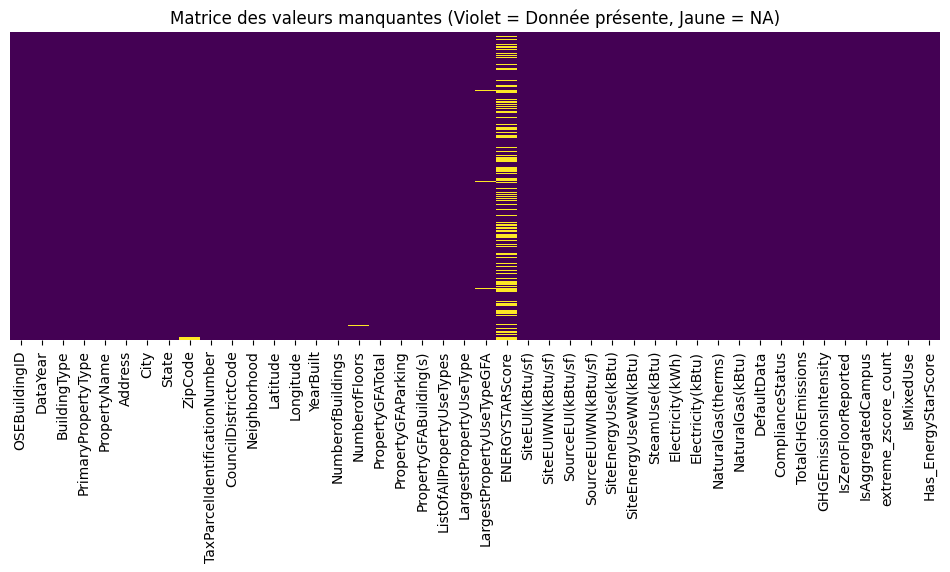

In [5]:
plt.figure(figsize=(12, 4))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Matrice des valeurs manquantes (Violet = Donnée présente, Jaune = NA)")
plt.show()

# Section 2 : Split train-test

In [6]:
df_cleaned["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'K-12 School', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Warehouse', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant'], dtype=object)

In [7]:
# Détection rapide des valeurs manquantes
TARGET = "TotalGHGEmissions"

print("NaN dans Target:", df_cleaned[TARGET].isna().sum())
print("Pourcentage:", df_cleaned[TARGET].isna().mean() * 100)

# NaN par type de bâtiment
print("\nNaN par PrimaryPropertyType:")
print(df_cleaned.groupby('PrimaryPropertyType')[TARGET].apply(lambda x: x.isna().sum()))

NaN dans Target: 0
Pourcentage: 0.0

NaN par PrimaryPropertyType:
PrimaryPropertyType
Distribution Center            0
Hospital                       0
Hotel                          0
K-12 School                    0
Laboratory                     0
Large Office                   0
Medical Office                 0
Mixed Use Property             0
Other                          0
Refrigerated Warehouse         0
Restaurant                     0
Retail Store                   0
Self-Storage Facility          0
Small- and Mid-Sized Office    0
Supermarket / Grocery Store    0
University                     0
Warehouse                      0
Worship Facility               0
Name: TotalGHGEmissions, dtype: int64


## Split avant feature engineering et log transformation de target

In [8]:
TARGET = "TotalGHGEmissions"
X = df_cleaned.drop(columns=[TARGET])
y = np.log1p(df_cleaned[TARGET])

# Le split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['PrimaryPropertyType']
)


## Feature Engineering 

>Note :En soit le Double Feature Engineering est une erreur :si run_feature_engineering_pipeline calcule des moyennes ou des medianes sur le teste alors cela créer du leakage: le test est transformé avec ses propres statistiques au lieu de celles du train .Dans notre cas tel n'est pas le cas.Auncun probléme n'interviens et au vue du code cela revient au même que de regrouper les deux .Pour des contraintes de temps nous conservons notre demarche

In [9]:

# En cas d'éventuel calcul groupé lors du feature enginenning

logger.info(" Feature Engineering sur TRAIN ")
X_train.name = "X_train"
X_test.name = "X_test"
# Ces transformations doivent être conçues pour n'utiliser que les données de X_train en cas d'utilisation de stats globale
df_train_fe = run_feature_engineering_pipeline(X_train, cfg_ml)
y_train = y_train.loc[df_train_fe.index]  # Réaligner les cibles 

logger.info(" Feature Engineering sur TEST ")
# Appliquez les MÊMES transformations au test, sans ré-apprendre de paramètres.
df_test_fe = run_feature_engineering_pipeline(X_test, cfg_ml)
y_test = y_test.loc[df_test_fe.index]

#  Préparation  pour le pipeline ML
X_train_clean = df_train_fe.copy()
X_test_clean = df_test_fe.copy()


2026-01-13 13:15:41,557 -  Feature Engineering sur TRAIN 
2026-01-13 13:15:41,559 - --- Démarrage : Feature Engineering ---
2026-01-13 13:15:41,762 - ✓ Feature Engineering terminé. Shape: (1136, 20)
2026-01-13 13:15:41,766 -  Feature Engineering sur TEST 
2026-01-13 13:15:41,769 - --- Démarrage : Feature Engineering ---
2026-01-13 13:15:41,851 - ✓ Feature Engineering terminé. Shape: (285, 20)


✓ Feature engineering sauvegardé dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed\X_train.csv
✓ Feature engineering sauvegardé dans : C:\Users\DELL\Desktop\ise2\Informatique\ML 1\projet machine learning 1\ML-prediction-CO2\data\processed\X_test.csv


In [10]:
X_train_clean.columns

Index(['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore',
       'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude',
       'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA',
       'surface_per_building', 'surface_per_floor', 'Has_Parking',
       'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam',
       'Age_ENERGYSTAR'],
      dtype='object')

In [11]:
X_train_clean.shape

(1136, 20)

In [12]:
X_test.shape

(285, 43)

In [13]:
y_train.head()

1191    3.923556
1968    3.379974
980     4.879615
119     7.628916
2087    2.989211
Name: TotalGHGEmissions, dtype: float64

# Section 3 : Modéle baseline

In [14]:
print(X_train_clean.columns.tolist())

['NumberofFloors', 'NumberofBuildings', 'Age', 'ENERGYSTARScore', 'PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'Latitude', 'Longitude', 'Is_Downtown', 'distance_to_center_proxy', 'log_GFA', 'surface_per_building', 'surface_per_floor', 'Has_Parking', 'Parking_share', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam', 'Age_ENERGYSTAR']


## Custom Transformers

In [15]:

# clé de regroupement
GROUP_COL = "PrimaryPropertyType"


# Exclure PrimaryPropertyType des colonnes catégorielles à imputer

cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()

# colonnes catégorielles À IMPUTER (sans la clé de groupe)
categorical_features = [c for c in cat_cols if c != GROUP_COL]


In [16]:


num_cols = X_train_clean.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, min_group_size: int = 1):
        self.group_col = group_col
        self.min_group_size = min_group_size
        self.integer_cols_ = [] # Pour stocker les colonnes qui doivent être arrondies

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        
        # Identifier les colonnes numériques
        numeric_cols = X.select_dtypes(include="number").columns
        
        # Détecter les colonnes "purement entières" (ex: 1.0, 2.0, NaN)
        self.integer_cols_ = []
        for col in numeric_cols:
            non_na_values = X[col].dropna()
            if not non_na_values.empty and (non_na_values % 1 == 0).all():
                self.integer_cols_.append(col)

        # Compter et calculer médianes par groupe
        group_counts = X.groupby(self.group_col).size()
        medians = X.groupby(self.group_col).median(numeric_only=True)

        for g, cnt in group_counts.items():
            if cnt < self.min_group_size and g in medians.index:
                medians.loc[g, :] = np.nan
        
        self.group_medians_ = medians
        self.global_median_ = X.median(numeric_only=True)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.group_medians_.columns:
            if col not in X.columns:
                continue
            
            # Imputation par groupe puis globale
            X[col] = X[col].fillna(X[self.group_col].map(self.group_medians_[col]))
            X[col] = X[col].fillna(self.global_median_[col])
            
            # Si la colonne était initialement composée d'entiers, on arrondit au supérieur
            if col in self.integer_cols_:
                X[col] = np.ceil(X[col]).astype(int)
                
        return X.drop(columns=[self.group_col], errors="ignore")

class GroupModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, categorical_cols=None, min_group_size: int = 1):
        # ne pas transformer categorical_cols ici 
        self.group_col = group_col
        self.categorical_cols = categorical_cols  # peut être None ; on infère dans fit()
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # si categorical_cols n'est pas fourni, inférer toutes les colonnes sans 'group_col' de type object/category
        if self.categorical_cols is None:
            inferred = X.select_dtypes(include=["object", "category"]).columns.tolist()
            self.categorical_cols = [c for c in inferred if c != self.group_col]
        # calculer mode par groupe
        group_counts = X.groupby(self.group_col).size()
        self.group_modes_ = {}
        for col in self.categorical_cols:
            modes = X.groupby(self.group_col)[col].agg(
                lambda s: s.mode().iloc[0] if not s.mode().empty else None
            )
            for g, cnt in group_counts.items():
                if cnt < self.min_group_size and g in modes.index:
                    modes.loc[g] = None
            self.group_modes_[col] = modes
        # global modes fallback
        self.global_modes_ = {col: X[col].mode().iloc[0] for col in self.categorical_cols}
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.categorical_cols:
            if col not in X.columns:
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_modes_.get(col, pd.Series())))
            X[col] = X[col].fillna(self.global_modes_.get(col))
        # conserver la colonne de regroupement avant l'encodeur
        return X



## Construction des Pipelines

In [17]:

# construire pipelines


numeric_pipeline = Pipeline([
    ("imputer", GroupMedianImputer(group_col=GROUP_COL, min_group_size=1)),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", GroupModeImputer(group_col=GROUP_COL, categorical_cols=categorical_features, min_group_size=1)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) # handle_unknown="ignore" pour Les nouvelles catégories rencontrées dans les données de test sont ignorées
    #  sparse_output=False pour facilier la conversion en dataframe de la matrice OneHotEncoder

# ColumnTransformer : on transmet [GROUP_COL] + cols à chaque sous-pipeline
# Applique numeric_pipeline sur [GROUP_COL] + num_cols (GROUP_COL passé pour imputation, puis supprimé)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, [GROUP_COL] + num_cols),
        ("cat", categorical_pipeline,cat_cols),
    ],
    remainder="drop"
)



### Entraînement et comparaison de modèles non-linéaires : modèle avec ENERGYSTARSCORE

Ce bloc entraîne plusieurs modèles non-linéaires (RandomForest, GradientBoosting, HistGradientBoosting, SVR, et XGBoost etc.), compare leurs performances (MAE, RMSE, R²,MAPE), choisit le meilleur modèle puis sauvegarde le pipeline complet dans un dossier `models/` à la racine du projet.


In [27]:
import joblib
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Modèles linéaires
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    SGDRegressor,
    HuberRegressor,
    RANSACRegressor,
    TheilSenRegressor
)

# Modèles d'ensemble
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor
)

# Autres modèles
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Outils
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score,
    mean_absolute_percentage_error
)

In [ ]:
# Dictionnaire des modèles finaux à comparer

models = {
    # Modèles linéaires
    "Linear Regression": LinearRegression(
        n_jobs=-1
    ),
    
    "Ridge": Ridge(
        alpha=1.0,
        solver="auto",
        random_state=42
    ),
    
    "Lasso": Lasso(
        alpha=0.1,
        max_iter=2000,
        random_state=42
    ),
    
    "ElasticNet": ElasticNet(
        alpha=0.1,
        l1_ratio=0.5,
        max_iter=2000,
        random_state=42
    ),
    
    "Bayesian Ridge": BayesianRidge(
        n_iter=300,
        alpha_1=1e-6,
        alpha_2=1e-6,
        lambda_1=1e-6,
        lambda_2=1e-6
    ),
    
    "SGD Regressor": SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=0.0001,
        learning_rate="invscaling",
        max_iter=2000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ),
    
    "Huber Regressor": HuberRegressor(
        epsilon=1.35,
        alpha=0.0001,
        max_iter=200
    ),
    
    # Modèles d'ensemble
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),

    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_iter=300,
        learning_rate=0.05,
        max_depth=10,
        l2_regularization=0.1,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),

    # Autres modèles
    "SVR": SVR(
        kernel="rbf",
        C=50,
        gamma="scale",
        epsilon=0.1
    ),

    "KNN": KNeighborsRegressor(
        n_neighbors=9,
        weights="distance",
        metric="minkowski",
        p=2
    ),

    "MLP": MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=0.001,
        learning_rate="adaptive",
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=1000,
        random_state=42
    )
}

In [29]:
from sklearn.pipeline import Pipeline
import pandas as pd

results = []
trained_models = {}
start_time = time.time()

for model_name, model in models.items():
    try:
        # Créer le pipeline complet
        ml_pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        
        # Entraînement
        t0 = time.time()
        ml_pipeline.fit(X_train_clean, y_train)
        train_time = time.time() - t0
        
        # Prédictions
        y_train_pred = ml_pipeline.predict(X_train_clean)
        y_test_pred = ml_pipeline.predict(X_test_clean)
        
        # Métriques sur TRAIN
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Métriques sur TEST
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Convertir les prédictions en espace original
        y_test_pred_original = np.expm1(y_test_pred)
        y_test_original = np.expm1(y_test)
        test_mae_original = mean_absolute_error(y_test_original, y_test_pred_original)
        test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
        
        # Calcul de l'overfitting
        overfitting_r2 = train_r2 - test_r2
        overfitting_rmse = test_rmse - train_rmse
        
        results.append({
            'Model': model_name,
            'Train_MAE': train_mae,
            'Train_RMSE': train_rmse,
            'Train_R2': train_r2,
            'Train_MAPE': train_mape,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Test_R2': test_r2,
            'Test_MAPE': test_mape,
            'Test_MAE_Original': test_mae_original,
            'Test_RMSE_Original': test_rmse_original,
            'Overfitting_R2': overfitting_r2,
            'Overfitting_RMSE': overfitting_rmse,
            'Train_Time_s': train_time
        })
        
        trained_models[model_name] = ml_pipeline
        
    except Exception as e:
        results.append({
            'Model': model_name,
            'Train_MAE': np.nan,
            'Train_RMSE': np.nan,
            'Train_R2': np.nan,
            'Train_MAPE': np.nan,
            'Test_MAE': np.nan,
            'Test_RMSE': np.nan,
            'Test_R2': np.nan,
            'Test_MAPE': np.nan,
            'Test_MAE_Original': np.nan,
            'Test_RMSE_Original': np.nan,
            'Overfitting_R2': np.nan,
            'Overfitting_RMSE': np.nan,
            'Train_Time_s': np.nan,
            'Error': str(e)
        })

# Créer le DataFrame des résultats
results_df = pd.DataFrame(results).set_index('Model')

# Trier par Test_R2
results_df = results_df.sort_values('Test_R2', ascending=False)

# Afficher
results_df

,Train_MAE,Train_RMSE,Train_R2,Train_MAPE,Test_MAE,Test_RMSE,Test_R2,Test_MAPE,Test_MAE_Original,Test_RMSE_Original,Overfitting_R2,Overfitting_RMSE,Train_Time_s
Model,,,,,,,,,,,,,
Gradient Boosting,2.188293e-01,2.859209e-01,0.957750,6.828822e-02,0.501599,0.650230,0.796072,0.159177,8.949714e+01,3.252794e+02,0.161678,0.364309,1.484776
XGBoost,1.049886e-01,1.418798e-01,0.989597,3.260588e-02,0.513246,0.665365,0.786468,0.164882,8.883645e+01,3.000734e+02,0.203128,0.523485,0.505239
Hist Gradient Boosting,2.205960e-01,2.873150e-01,0.957337,7.056272e-02,0.509406,0.667768,0.784923,0.160843,9.634423e+01,3.868805e+02,0.172414,0.380453,0.707135
Random Forest,3.841824e-01,5.017263e-01,0.869902,1.346281e-01,0.575935,0.746755,0.731033,0.191828,1.158393e+02,5.340682e+02,0.138869,0.245029,0.394753
SVR,2.672220e-01,4.387362e-01,0.900518,8.909439e-02,0.588251,0.772047,0.712505,0.176531,1.189606e+02,4.527948e+02,0.188013,0.333310,0.317577
KNN,4.249665e-08,1.235653e-07,1.000000,1.693602e-08,0.713465,0.912570,0.598324,0.242585,1.228300e+02,5.273973e+02,0.401676,0.912570,0.034127
MLP,4.507853e-01,6.302053e-01,0.794741,1.373257e-01,0.561986,0.986572,0.530538,0.167726,2.350501e+06,3.967931e+07,0.264204,0.356367,1.152220


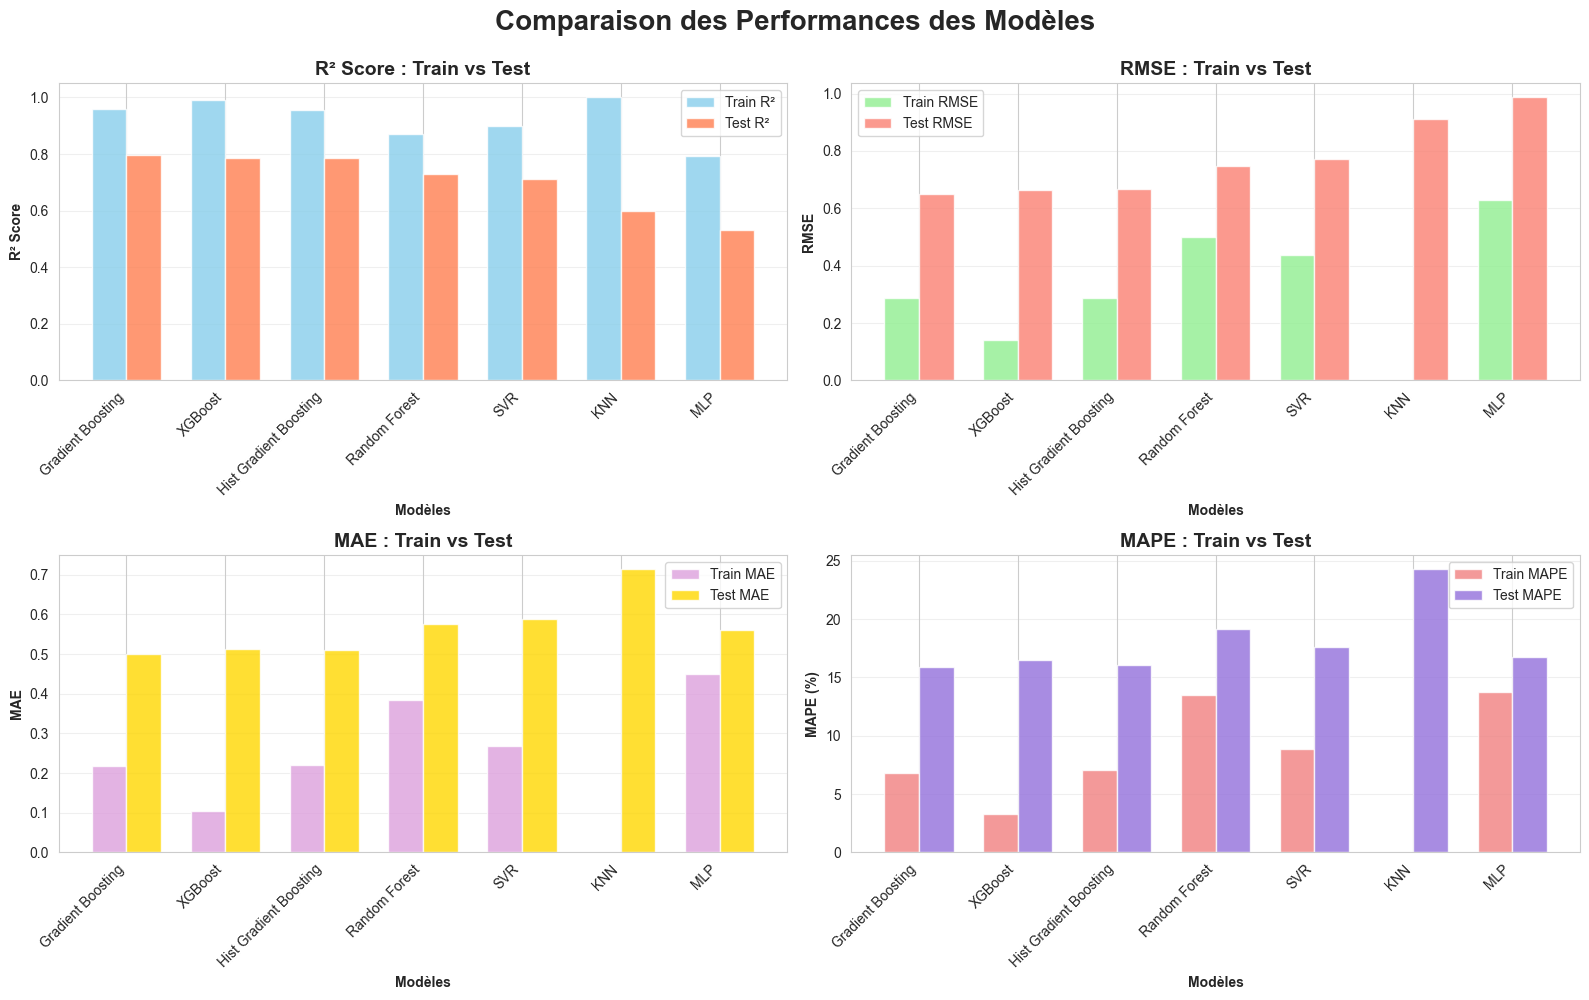

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Comparaison des Performances des Modèles', fontsize=20, fontweight='bold', y=0.995)

# Préparer les données (exclure les modèles avec erreurs)
plot_df = results_df.dropna(subset=['Test_R2'])

# 1. R² Score (Train vs Test)
ax1 = axes[0, 0]
x_pos = range(len(plot_df))
width = 0.35
ax1.bar([i - width/2 for i in x_pos], plot_df['Train_R2'], width, label='Train R²', alpha=0.8, color='skyblue')
ax1.bar([i + width/2 for i in x_pos], plot_df['Test_R2'], width, label='Test R²', alpha=0.8, color='coral')
ax1.set_xlabel('Modèles', fontweight='bold')
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Score : Train vs Test', fontweight='bold', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(plot_df.index, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. RMSE (Train vs Test)
ax2 = axes[0, 1]
ax2.bar([i - width/2 for i in x_pos], plot_df['Train_RMSE'], width, label='Train RMSE', alpha=0.8, color='lightgreen')
ax2.bar([i + width/2 for i in x_pos], plot_df['Test_RMSE'], width, label='Test RMSE', alpha=0.8, color='salmon')
ax2.set_xlabel('Modèles', fontweight='bold')
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('RMSE : Train vs Test', fontweight='bold', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(plot_df.index, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. MAE (Train vs Test)
ax3 = axes[1, 0]
ax3.bar([i - width/2 for i in x_pos], plot_df['Train_MAE'], width, label='Train MAE', alpha=0.8, color='plum')
ax3.bar([i + width/2 for i in x_pos], plot_df['Test_MAE'], width, label='Test MAE', alpha=0.8, color='gold')
ax3.set_xlabel('Modèles', fontweight='bold')
ax3.set_ylabel('MAE', fontweight='bold')
ax3.set_title('MAE : Train vs Test', fontweight='bold', fontsize=14)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(plot_df.index, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. MAPE (Train vs Test)
ax4 = axes[1, 1]
ax4.bar([i - width/2 for i in x_pos], plot_df['Train_MAPE']*100, width, label='Train MAPE', alpha=0.8, color='lightcoral')
ax4.bar([i + width/2 for i in x_pos], plot_df['Test_MAPE']*100, width, label='Test MAPE', alpha=0.8, color='mediumpurple')
ax4.set_xlabel('Modèles', fontweight='bold')
ax4.set_ylabel('MAPE (%)', fontweight='bold')
ax4.set_title('MAPE : Train vs Test', fontweight='bold', fontsize=14)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(plot_df.index, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Résumé et fichiers sauvegardés

- Les modèles testés sont : Random Forest, Gradient Boosting, HistGradientBoosting, XGBoost, SVR, KNN et MLP.
- Les métriques calculées sont : **MAE**, **RMSE**, **R2**, **MAPE**.
- Fichiers générés et emplacement :
  - Comparaison complète : `models/model_comparison_<timestamp>.csv` ✅
  - Pipeline du meilleur modèle : `models/best_pipeline_<MODELNAME>_<timestamp>.joblib` ✅
  - Métriques du meilleur modèle : `models/best_metrics_<timestamp>.json` ✅

Prochaine étape : exécuter ce bloc pour valider l'entraînement et vérifier les artefacts dans `models/`.